In [1]:
import torch
from scipy.optimize import brentq,root_scalar
import scipy.stats as st
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
# load the confidence scores
clean_embds_S,clean_labels_S,clean_preds_S = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/mnv3small_clean224.pt")
clean_embds_T,clean_labels_T,clean_preds_T = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/resnet50_clean224.pt")
corr_embds_T = []
corr_labels_T = []
corr_preds_T = []
corr_embds_S = []
corr_labels_S = []
corr_preds_S = []
# corr_embds64 = []
# corr_labels64 = []
# corr_preds64 = []
for i,corr in enumerate(corruptions):
    e_S,l_S,p_S = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/sev3_mnv3small_corr224_"+corr+".pt")
    e_T,l_T,p_T = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/sev3_resnet50_corr224_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds_T.append(e_T)
    corr_labels_T.append(l_T)
    corr_preds_T.append(p_T)
    corr_embds_S.append(e_S)
    corr_labels_S.append(l_S)
    corr_preds_S.append(p_S)

setup parameters

In [21]:
n = 1000
alphas = [0.05,0.15,0.25]
rand_idxs = torch.randperm(50000)
rand_corr_order = torch.randperm(15)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]

initial calibration

In [22]:
student_confs,student_decs = torch.max(clean_preds_S,dim=1)
teacher_confs,teacher_decs = torch.max(clean_preds_T,dim=1)

student_cal_scores = student_confs[cal_idxs]
student_cal_preds = student_decs[cal_idxs]
teacher_cal_preds = teacher_decs[cal_idxs]

lambda_hats = []
mean_stud_uses = []

sub_lambda_hats = torch.zeros((len(alphas),45))

s_cost = 1
t_cost = 66

for i,alpha in enumerate(alphas):

    # zero-one loss
    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()

    # the lambda hat threshold, we want the largest lambda hat that we satisfy the condition
    def lamhat_threshold(lam): 
        p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
        return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1))

    if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
    elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
    else:
        lamhat = brentq(lamhat_threshold, 0, 1)
        
    lambda_hats.append(lamhat)

    # mean = (student_cal_scores >= lambda_hats[i]).float().mean()
    # std = (student_cal_scores >= lambda_hats[i]).float().std()
    # lower = mean-st.norm.ppf(1-(0.05)/2)*(std/np.sqrt(len(student_cal_preds)))
    # upper = mean+st.norm.ppf(1-(0.05)/2)*(std/np.sqrt(len(student_cal_preds)))
    # lower = lower + (1-lower)*10
    # upper = upper + (1-upper)*10
    # mean_stud_uses.append([lower,upper])

# find deltas dynamically through random sampling (sparse since comes at cost)
for i,alpha in enumerate(alphas):
    # 45 here means we adjust every 1000 samples and we have 45000 samples
    for j in range(45):
        
        start = 4000+j*1000 # when to start the current observation
        corr_i = j // 3 # the corruption to use
        # print(f"start:{start},corr_i:{corr_i}")

        student_confs_,student_decs_ = torch.max(corr_preds_S[rand_corr_order[corr_i]],dim=1)
        teacher_confs_,teacher_decs_ = torch.max(corr_preds_T[rand_corr_order[corr_i]],dim=1)

        student_val_scores_ = student_confs_[val_idxs]
        student_val_preds_ = student_decs_[val_idxs]
        teacher_val_preds_ = teacher_decs_[val_idxs]

        rand_cal_idxs = torch.randperm(1000)[:100] + start # randomly sample 100 of the 1000
        # print(start,rand_cal_idxs)

        # zero-one loss
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()

        # the lambda hat threshold, we want the largest lambda hat that we satisfy the condition
        def lamhat_threshold(lam): 
            p_set = (student_val_scores_[rand_cal_idxs] >= lam)*student_val_preds_[rand_cal_idxs] + (student_val_scores_[rand_cal_idxs] < lam)*teacher_val_preds_[rand_cal_idxs]
            return zo_loss(p_set, teacher_val_preds_[rand_cal_idxs]) - ((n+1)/n*alpha - 1/(n+1))

        sub_lambda_hats[i,j] = brentq(lamhat_threshold, 0, 1)

print(lambda_hats)
print(sub_lambda_hats)


[0.6074368655690097, 0.34260554611822985, 0.13219491392397853]
tensor([[0.6414, 0.7993, 0.9036, 0.5201, 0.5853, 0.5949, 0.6935, 0.5004, 0.7639,
         0.6350, 0.5558, 0.5543, 0.5126, 0.4424, 0.7081, 0.7301, 0.7044, 0.7480,
         0.7167, 0.4903, 0.4400, 0.7033, 0.6159, 0.6325, 0.6160, 0.5750, 0.6570,
         0.6227, 0.7671, 0.7284, 0.6238, 0.8230, 0.6531, 0.4305, 0.5330, 0.4947,
         0.7879, 0.7682, 0.7097, 0.6286, 0.6274, 0.5180, 0.6169, 0.6495, 0.7327],
        [0.4634, 0.5006, 0.5414, 0.3878, 0.3778, 0.2952, 0.3557, 0.3768, 0.3903,
         0.4510, 0.4997, 0.3751, 0.2785, 0.3453, 0.3866, 0.4703, 0.4033, 0.3612,
         0.3240, 0.2800, 0.2887, 0.3858, 0.4338, 0.3558, 0.3851, 0.3302, 0.2974,
         0.3717, 0.3905, 0.4372, 0.4367, 0.4818, 0.4059, 0.2192, 0.2610, 0.2652,
         0.4439, 0.3783, 0.5066, 0.4444, 0.3922, 0.4275, 0.4520, 0.3841, 0.4267],
        [0.4041, 0.3661, 0.3232, 0.1962, 0.1165, 0.3228, 0.3417, 0.3381, 0.2501,
         0.3440, 0.2956, 0.3347, 0.2101, 0.2

testing
* 49000 test points
    * 4000 clean, 3000 per corruption
* store average risk, acc, and cost over last 1000

In [23]:
# store running stats
policy_dec = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
policy_pred = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
student_pred = torch.zeros(len(val_idxs),dtype=int)
teacher_pred = torch.zeros(len(val_idxs),dtype=int)

policy_dec_clean = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
policy_pred_clean = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
student_pred_clean = torch.zeros(len(val_idxs),dtype=int)
teacher_pred_clean = torch.zeros(len(val_idxs),dtype=int)

policy_dec_adapt = torch.zeros((len(alphas),len(val_idxs)),dtype=int)
policy_pred_adapt = torch.zeros((len(alphas),len(val_idxs)),dtype=int)

# clean predictions
student_val_scores = student_confs[val_idxs]
student_val_preds = student_decs[val_idxs]
teacher_val_preds = teacher_decs[val_idxs]

# try three different alphas
for alpha_i,alpha in enumerate(alphas):
    # get decision for clean samples (1 = student, 0 = teacher)
    policy_dec[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])
    policy_pred[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])*student_val_preds[:4000] + \
                                 (student_val_scores[:4000] < lambda_hats[alpha_i])*teacher_val_preds[:4000]
    student_pred[:4000] = student_val_preds[:4000]
    teacher_pred[:4000] = teacher_val_preds[:4000]

    policy_dec_clean[alpha_i,:] = (student_val_scores[:] >= lambda_hats[alpha_i])
    policy_pred_clean[alpha_i,:] = (student_val_scores[:] >= lambda_hats[alpha_i])*student_val_preds[:] + \
                                 (student_val_scores[:] < lambda_hats[alpha_i])*teacher_val_preds[:]
    student_pred_clean[:] = student_val_preds[:]
    teacher_pred_clean[:] = teacher_val_preds[:]

    policy_dec_adapt[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])
    policy_pred_adapt[alpha_i,:4000] = (student_val_scores[:4000] >= lambda_hats[alpha_i])*student_val_preds[:4000] + \
                                 (student_val_scores[:4000] < lambda_hats[alpha_i])*teacher_val_preds[:4000]

    # get decision for each corruption
    for corr_i,corruption in enumerate(corruptions):
        student_confs_,student_decs_ = torch.max(corr_preds_S[rand_corr_order[corr_i]],dim=1)
        teacher_confs_,teacher_decs_ = torch.max(corr_preds_T[rand_corr_order[corr_i]],dim=1)

        student_val_scores_ = student_confs_[val_idxs]
        student_val_preds_ = student_decs_[val_idxs]
        teacher_val_preds_ = teacher_decs_[val_idxs]

        # get decision for corrupt samples (1 = student, 0 = teacher)
        start = 4000+corr_i*3000
        stop = 4000+(corr_i+1)*3000
        policy_dec[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])
        policy_pred[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])*student_val_preds_[start:stop] + \
                                          (student_val_scores_[start:stop] < lambda_hats[alpha_i])*teacher_val_preds_[start:stop]
        student_pred[start:stop] = student_val_preds_[start:stop]
        teacher_pred[start:stop] = teacher_val_preds_[start:stop]

    # dynamic adjusting lambda
    for sub_i in range(45):
        corr_i = sub_i // 3
        student_confs_,student_decs_ = torch.max(corr_preds_S[rand_corr_order[corr_i]],dim=1)
        teacher_confs_,teacher_decs_ = torch.max(corr_preds_T[rand_corr_order[corr_i]],dim=1)

        student_val_scores_ = student_confs_[val_idxs]
        student_val_preds_ = student_decs_[val_idxs]
        teacher_val_preds_ = teacher_decs_[val_idxs]

        start = 4000+(sub_i)*1000
        stop = 4000+(sub_i+1)*1000
        # initially (first 1000) we use the first lambda until we get an estimate
        if start == 4000:
            policy_dec_adapt[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])
            policy_pred_adapt[alpha_i,start:stop] = (student_val_scores_[start:stop] >= lambda_hats[alpha_i])*student_val_preds_[start:stop] + \
                                                    (student_val_scores_[start:stop] < lambda_hats[alpha_i])*teacher_val_preds_[start:stop]
        else:
            # print(start,stop,sub_lambda_hats[alpha_i,sub_i-1],lambda_hats[alpha_i])
            # print(start,stop,sub_lambda_hats[alpha_i,sub_i-1])
            policy_dec_adapt[alpha_i,start:stop] = (student_val_scores_[start:stop] >= sub_lambda_hats[alpha_i,sub_i-1])
            policy_pred_adapt[alpha_i,start:stop] = (student_val_scores_[start:stop] >= sub_lambda_hats[alpha_i,sub_i-1])*student_val_preds_[start:stop] + \
                                                    (student_val_scores_[start:stop] < sub_lambda_hats[alpha_i,sub_i-1])*teacher_val_preds_[start:stop]

get the stats

In [24]:
local_avg_risk = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_t = torch.zeros(len(val_idxs))
local_avg_cost = torch.zeros((len(alphas),len(val_idxs)))
avg_risk = torch.zeros(len(alphas))
avg_acc = torch.zeros(len(alphas))
avg_acc_t = 0
avg_cost = torch.zeros(len(alphas))

local_avg_risk_clean = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_clean = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_t_clean = torch.zeros(len(val_idxs))
local_avg_cost_clean = torch.zeros((len(alphas),len(val_idxs)))
avg_risk_clean = torch.zeros(len(alphas))
avg_acc_clean = torch.zeros(len(alphas))
avg_acc_t_clean = 0
avg_cost_clean = torch.zeros(len(alphas))

local_avg_risk_adapt = torch.zeros((len(alphas),len(val_idxs)))
local_avg_acc_adapt = torch.zeros((len(alphas),len(val_idxs)))
local_avg_cost_adapt = torch.zeros((len(alphas),len(val_idxs)))
avg_risk_adapt = torch.zeros(len(alphas))
avg_acc_adapt = torch.zeros(len(alphas))
avg_cost_adapt = torch.zeros(len(alphas))

bern_local = torch.zeros((len(alphas),len(val_idxs)))
bern = torch.rand(49000)

window_size = 1000
gt_val = corr_labels_T[0][val_idxs]

for idx,sample in enumerate(tqdm(policy_dec[0])):
    start = 0 if idx <= window_size else idx - window_size
    stop = idx+1
    for alpha_i,alpha in enumerate(alphas):
        local_avg_risk[alpha_i,idx] = (policy_pred[alpha_i,start:stop] != teacher_pred[start:stop]).float().mean()
        local_avg_acc[alpha_i,idx] = (policy_pred[alpha_i,start:stop] == gt_val[start:stop]).float().mean()
        local_avg_acc_t[idx] = (teacher_pred[start:stop] == gt_val[start:stop]).float().mean()
        local_avg_cost[alpha_i,idx] = ((policy_dec[alpha_i,start:stop] == 1)*s_cost + (policy_dec[alpha_i,start:stop] == 0)*t_cost).float().mean()

        local_avg_risk_clean[alpha_i,idx] = (policy_pred_clean[alpha_i,start:stop] != teacher_pred_clean[start:stop]).float().mean()
        local_avg_acc_clean[alpha_i,idx] = (policy_pred_clean[alpha_i,start:stop] == gt_val[start:stop]).float().mean()
        local_avg_acc_t_clean[idx] = (teacher_pred_clean[start:stop] == gt_val[start:stop]).float().mean()
        local_avg_cost_clean[alpha_i,idx] = ((policy_dec_clean[alpha_i,start:stop] == 1)*s_cost + (policy_dec_clean[alpha_i,start:stop] == 0)*t_cost).float().mean()

        local_avg_risk_adapt[alpha_i,idx] = (policy_pred_adapt[alpha_i,start:stop] != teacher_pred[start:stop]).float().mean()
        local_avg_acc_adapt[alpha_i,idx] = (policy_pred_adapt[alpha_i,start:stop] == gt_val[start:stop]).float().mean()

        rem_percent = 0.1 - (policy_dec_adapt[alpha_i,start:stop] == 0).float().mean()*.1
        local_avg_cost_adapt[alpha_i,idx] = (((policy_dec_adapt[alpha_i,start:stop] == 1)*s_cost + (policy_dec_adapt[alpha_i,start:stop] == 0)*t_cost).float().sum() + (stop-start)*rem_percent*t_cost)/(stop-start)

        bern_local[alpha_i,idx] = ((bern < alpha)[start:stop]).float().mean()

for alpha_i,alpha in enumerate(alphas):
    avg_risk[alpha_i] = (policy_pred[alpha_i,:] != teacher_pred[:]).float().mean()
    avg_acc[alpha_i] = (policy_pred[alpha_i,:] == gt_val[:]).float().mean()
    avg_acc_t = (teacher_pred[:] == gt_val[:]).float().mean()
    avg_cost[alpha_i] = ((policy_dec[alpha_i,:] == 1)*s_cost + (policy_dec[alpha_i,:] == 0)*t_cost).float().mean()

    avg_risk_clean[alpha_i] = (policy_pred_clean[alpha_i,:] != teacher_pred_clean[:]).float().mean()
    avg_acc_clean[alpha_i] = (policy_pred_clean[alpha_i,:] == gt_val[:]).float().mean()
    avg_acc_t_clean = (teacher_pred_clean[:] == gt_val[:]).float().mean()
    avg_cost_clean[alpha_i] = ((policy_dec_clean[alpha_i,:] == 1)*s_cost + (policy_dec_clean[alpha_i,:] == 0)*t_cost).float().mean()

    avg_risk_adapt[alpha_i] = (policy_pred_adapt[alpha_i,:] != teacher_pred[:]).float().mean()
    avg_acc_adapt[alpha_i] = (policy_pred_adapt[alpha_i,:] == gt_val[:]).float().mean()
    rem_amnt = 4900 - (policy_dec_adapt[alpha_i,:] == 0).float().sum()*.1
    avg_cost_adapt[alpha_i] = (((policy_dec_adapt[alpha_i,:] == 1)*s_cost + (policy_dec_adapt[alpha_i,:] == 0)*t_cost).sum()+rem_amnt*t_cost)/(policy_dec_adapt.shape[1])

100%|██████████| 49000/49000 [00:39<00:00, 1241.93it/s]


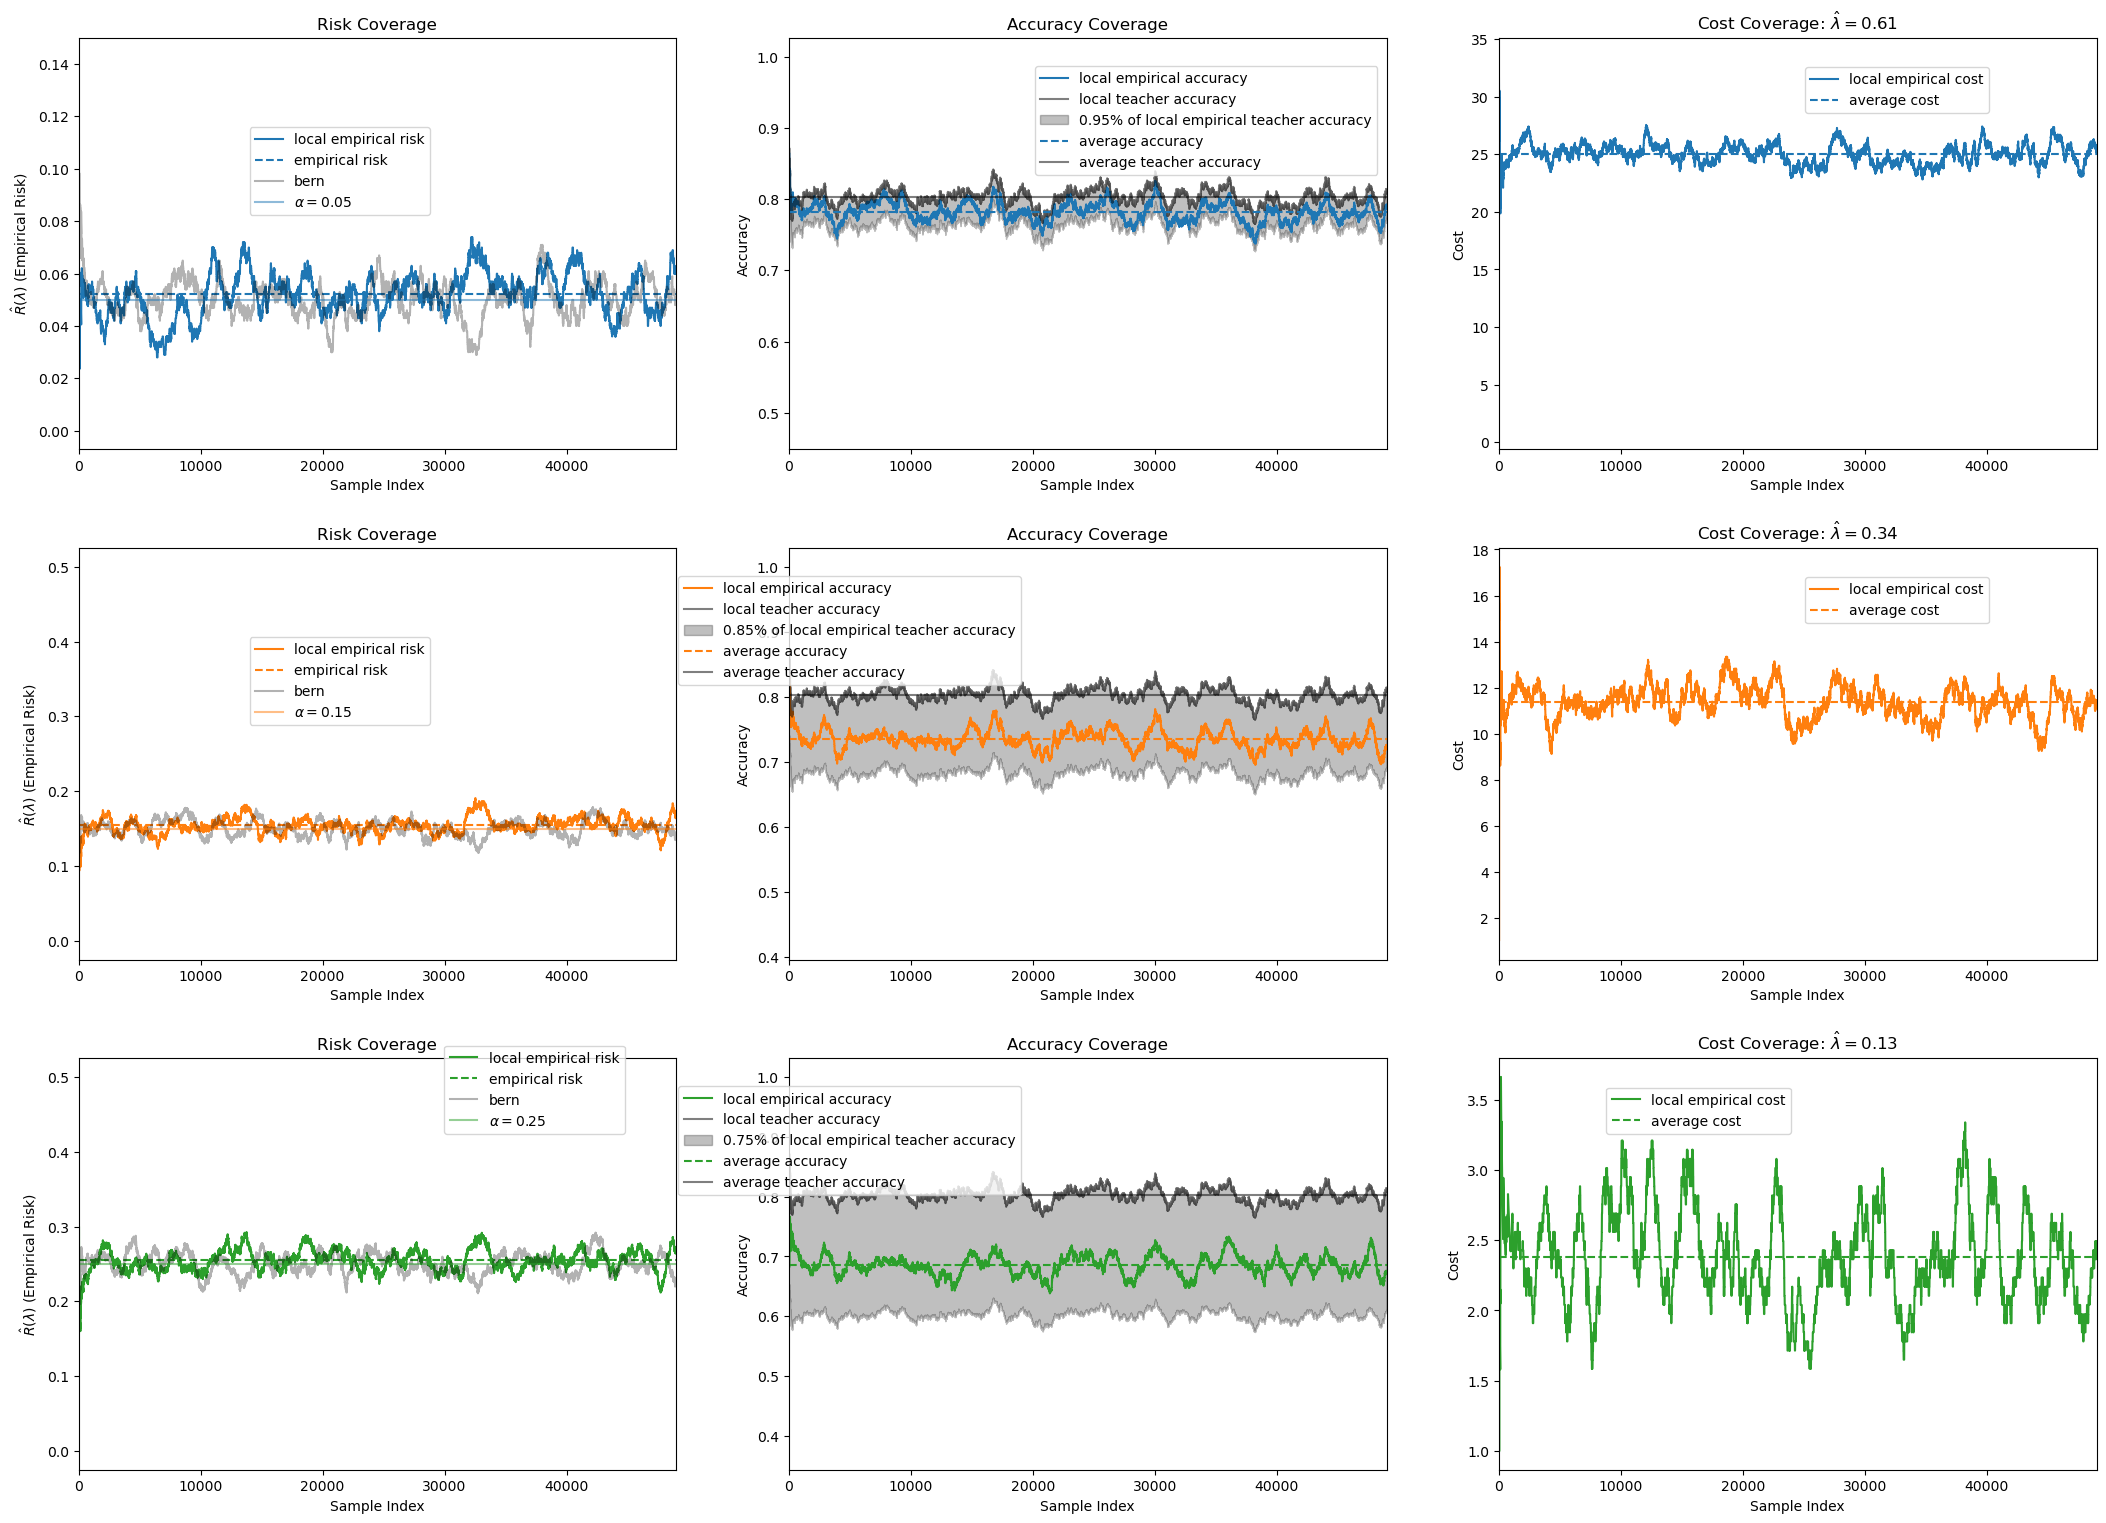

: 

In [29]:
fig, ax = plt.subplots(3,3,figsize=(22,16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig.tight_layout(pad=5.0)
for alpha_i,alpha in enumerate(alphas):
    # risk
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),local_avg_risk_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical risk")
    ax[alpha_i,0].axhline(avg_risk_clean[alpha_i],c=cycle[alpha_i],linestyle="--",label="empirical risk")
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),bern_local[alpha_i,:],c='k',alpha=0.3,label="bern")
    ax[alpha_i,0].axhline(alpha,c=cycle[alpha_i],label=r'$\alpha=$'+str(alpha),alpha=0.5)
    ax[alpha_i,0].set_title("Risk Coverage")
    ax[alpha_i,0].set_xlabel("Sample Index")
    ax[alpha_i,0].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')
    ax[alpha_i,0].set_xlim([0,49000])
    # ax[alpha_i,0].set_ylim([0,0.4])

    # accuracy
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical accuracy")
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_t_clean[:],c='k',label="local teacher accuracy",alpha=0.5)
    ax[alpha_i,1].fill_between(torch.arange(0,len(val_idxs)),(1-alpha)*local_avg_acc_t_clean,local_avg_acc_t_clean,color='k',alpha=0.25,label=str(1-alpha)+"% of local empirical teacher accuracy")
    ax[alpha_i,1].axhline(avg_acc_clean[alpha_i],c=cycle[alpha_i],linestyle="--",label="average accuracy")
    ax[alpha_i,1].axhline(avg_acc_t_clean,c='k',alpha=0.5,label="average teacher accuracy")
    ax[alpha_i,1].set_title("Accuracy Coverage")
    ax[alpha_i,1].set_xlabel("Sample Index")
    ax[alpha_i,1].set_ylabel("Accuracy")
    ax[alpha_i,1].set_xlim([0,49000])
    # ax[alpha_i,1].set_ylim([0.45,1])
    # maybe add fill between on total average?
    # cost
    ax[alpha_i,2].plot(torch.arange(0,len(val_idxs)),local_avg_cost_clean[alpha_i,:],c=cycle[alpha_i],label="local empirical cost")
    ax[alpha_i,2].axhline(avg_cost_clean[alpha_i],c=cycle[alpha_i],linestyle="--",label="average cost")
    # ax[alpha_i,2].axhline(sum(mean_stud_uses[alpha_i])/2,c=cycle[alpha_i],linestyle="--",label="predicted cost")
    # ax[alpha_i,2].fill_between(torch.arange(0,len(val_idxs)),torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][0],torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][1],color=cycle[alpha_i],alpha=0.25)
    ax[alpha_i,2].set_title(r'Cost Coverage: $\hat{\lambda}=$'+str(round(lambda_hats[alpha_i],2)))
    ax[alpha_i,2].set_xlabel("Sample Index")
    ax[alpha_i,2].set_ylabel("Cost")
    # ax[alpha_i,2].set_ylim([0,10])
    ax[alpha_i,2].set_xlim([0,49000])

    ax[alpha_i,0].legend(bbox_to_anchor=(0.6,0.8))
    ax[alpha_i,1].legend(bbox_to_anchor=(0.4,0.65))
    ax[alpha_i,2].legend(bbox_to_anchor=(0.5,0.8))

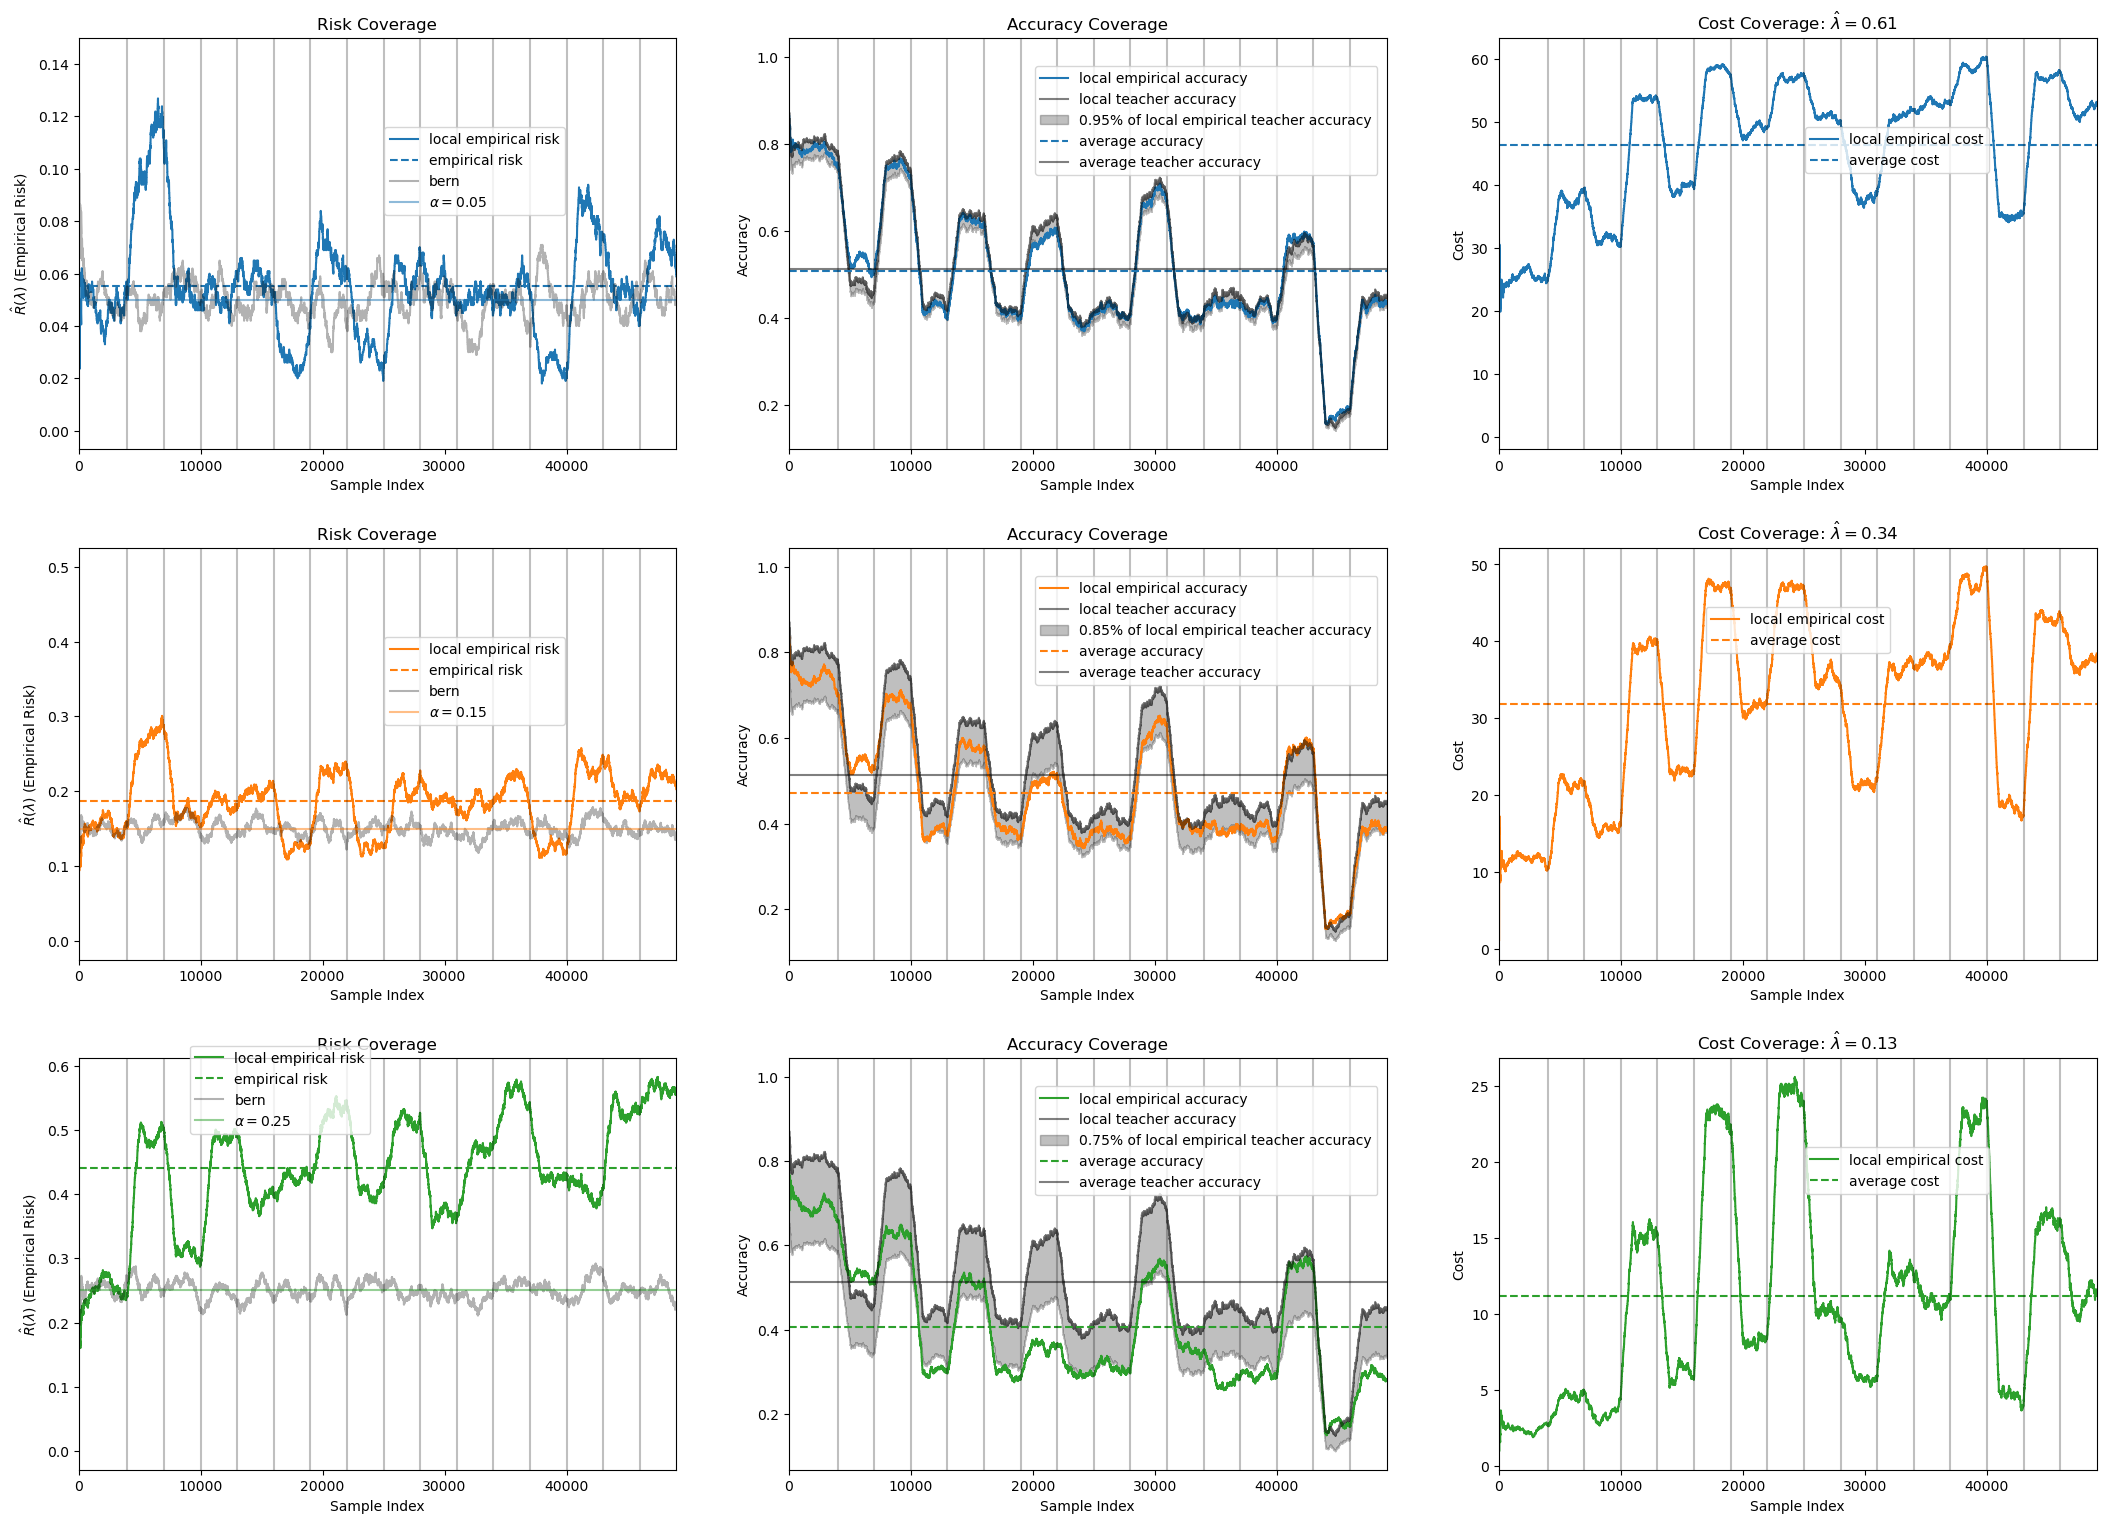

In [28]:
fig, ax = plt.subplots(3,3,figsize=(22,16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig.tight_layout(pad=5.0)
for alpha_i,alpha in enumerate(alphas):
    # risk
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),local_avg_risk[alpha_i,:],c=cycle[alpha_i],label="local empirical risk")
    ax[alpha_i,0].axhline(avg_risk[alpha_i],c=cycle[alpha_i],linestyle="--",label="empirical risk")
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),bern_local[alpha_i,:],c='k',alpha=0.3,label="bern")
    ax[alpha_i,0].axhline(alpha,c=cycle[alpha_i],label=r'$\alpha=$'+str(alpha),alpha=0.5)
    ax[alpha_i,0].set_title("Risk Coverage")
    ax[alpha_i,0].set_xlabel("Sample Index")
    ax[alpha_i,0].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')
    for i in range(15):
        ax[alpha_i,0].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,0].set_xlim([0,49000])
    # ax[alpha_i,0].set_ylim([0,0.4])
    # accuracy
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc[alpha_i,:],c=cycle[alpha_i],label="local empirical accuracy")
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_t[:],c='k',label="local teacher accuracy",alpha=0.5)
    ax[alpha_i,1].fill_between(torch.arange(0,len(val_idxs)),(1-alpha)*local_avg_acc_t,local_avg_acc_t,color='k',alpha=0.25,label=str(1-alpha)+"% of local empirical teacher accuracy")
    ax[alpha_i,1].axhline(avg_acc[alpha_i],c=cycle[alpha_i],linestyle="--",label="average accuracy")
    ax[alpha_i,1].axhline(avg_acc_t,c='k',alpha=0.5,label="average teacher accuracy")
    ax[alpha_i,1].set_title("Accuracy Coverage")
    ax[alpha_i,1].set_xlabel("Sample Index")
    ax[alpha_i,1].set_ylabel("Accuracy")
    for i in range(15):
        ax[alpha_i,1].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,1].set_xlim([0,49000])
    # ax[alpha_i,1].set_ylim([0.3,1])
    # maybe add fill between on total average?
    # cost
    ax[alpha_i,2].plot(torch.arange(0,len(val_idxs)),local_avg_cost[alpha_i,:],c=cycle[alpha_i],label="local empirical cost")
    ax[alpha_i,2].axhline(avg_cost[alpha_i],c=cycle[alpha_i],linestyle="--",label="average cost")
    # ax[alpha_i,2].axhline(sum(mean_stud_uses[alpha_i])/2,c=cycle[alpha_i],linestyle="--",label="predicted cost")
    # ax[alpha_i,2].fill_between(torch.arange(0,len(val_idxs)),torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][0],torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][1],color=cycle[alpha_i],alpha=0.25)
    ax[alpha_i,2].set_title(r'Cost Coverage: $\hat{\lambda}=$'+str(round(lambda_hats[alpha_i],2)))
    ax[alpha_i,2].set_xlabel("Sample Index")
    ax[alpha_i,2].set_ylabel("Cost")
    # ax[alpha_i,2].set_ylim([0,10])
    ax[alpha_i,2].set_xlim([0,49000])
    for i in range(15):
        ax[alpha_i,2].axvline(4000+i*3000,c='k',alpha=0.25)

    ax[alpha_i,0].legend(bbox_to_anchor=(0.5,0.8))
    ax[alpha_i,1].legend(bbox_to_anchor=(0.4,0.65))
    ax[alpha_i,2].legend(bbox_to_anchor=(0.5,0.8))


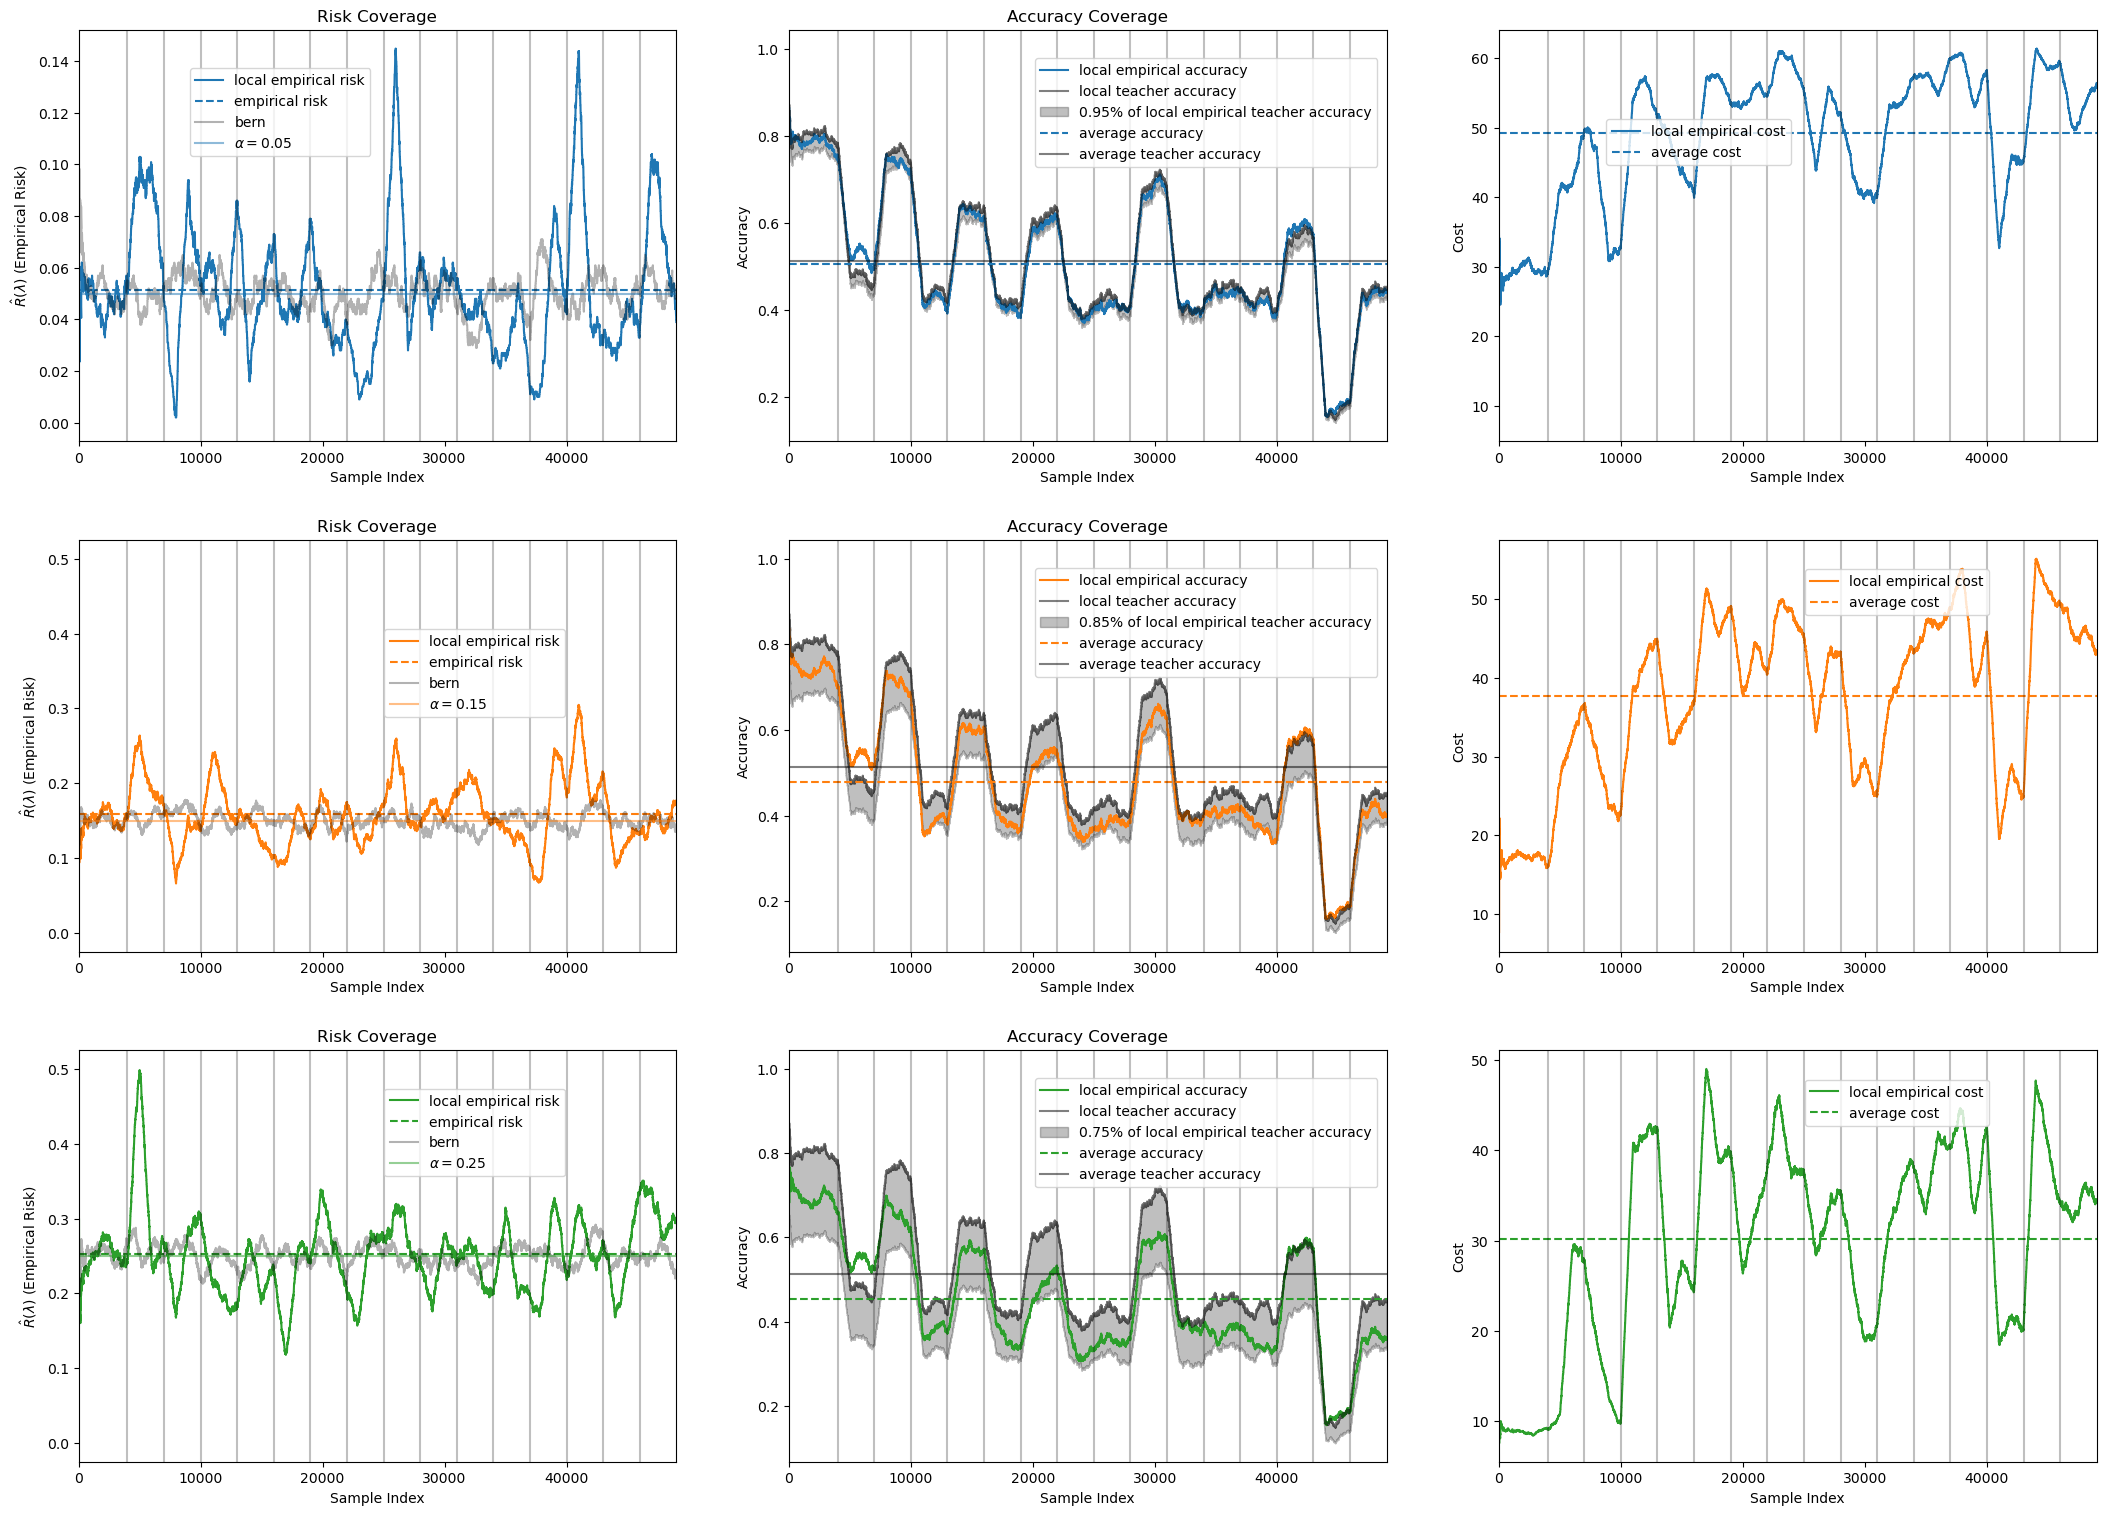

In [27]:
fig, ax = plt.subplots(3,3,figsize=(22,16))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig.tight_layout(pad=5.0)
for alpha_i,alpha in enumerate(alphas):
    # risk
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),local_avg_risk_adapt[alpha_i,:],c=cycle[alpha_i],label="local empirical risk")
    ax[alpha_i,0].axhline(avg_risk_adapt[alpha_i],c=cycle[alpha_i],linestyle="--",label="empirical risk")
    ax[alpha_i,0].plot(torch.arange(0,len(val_idxs)),bern_local[alpha_i,:],c='k',alpha=0.3,label="bern")
    ax[alpha_i,0].axhline(alpha,c=cycle[alpha_i],label=r'$\alpha=$'+str(alpha),alpha=0.5)
    ax[alpha_i,0].set_title("Risk Coverage")
    ax[alpha_i,0].set_xlabel("Sample Index")
    ax[alpha_i,0].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')
    for i in range(15):
        ax[alpha_i,0].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,0].set_xlim([0,49000])
    # ax[alpha_i,0].set_ylim([0,0.4])
    # accuracy
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_adapt[alpha_i,:],c=cycle[alpha_i],label="local empirical accuracy")
    ax[alpha_i,1].plot(torch.arange(0,len(val_idxs)),local_avg_acc_t[:],c='k',label="local teacher accuracy",alpha=0.5)
    ax[alpha_i,1].fill_between(torch.arange(0,len(val_idxs)),(1-alpha)*local_avg_acc_t,local_avg_acc_t,color='k',alpha=0.25,label=str(1-alpha)+"% of local empirical teacher accuracy")
    ax[alpha_i,1].axhline(avg_acc_adapt[alpha_i],c=cycle[alpha_i],linestyle="--",label="average accuracy")
    ax[alpha_i,1].axhline(avg_acc_t,c='k',alpha=0.5,label="average teacher accuracy")
    ax[alpha_i,1].set_title("Accuracy Coverage")
    ax[alpha_i,1].set_xlabel("Sample Index")
    ax[alpha_i,1].set_ylabel("Accuracy")
    for i in range(15):
        ax[alpha_i,1].axvline(4000+i*3000,c='k',alpha=0.25)
    ax[alpha_i,1].set_xlim([0,49000])
    # ax[alpha_i,1].set_ylim([0.3,1])
    # maybe add fill between on total average?
    # cost
    ax[alpha_i,2].plot(torch.arange(0,len(val_idxs)),local_avg_cost_adapt[alpha_i,:],c=cycle[alpha_i],label="local empirical cost")
    ax[alpha_i,2].axhline(avg_cost_adapt[alpha_i],c=cycle[alpha_i],linestyle="--",label="average cost")
    # ax[alpha_i,2].axhline(sum(mean_stud_uses[alpha_i])/2,c=cycle[alpha_i],linestyle="--",label="predicted cost")
    # ax[alpha_i,2].fill_between(torch.arange(0,len(val_idxs)),torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][0],torch.ones(len(val_idxs))*mean_stud_uses[alpha_i][1],color=cycle[alpha_i],alpha=0.25)
    # ax[alpha_i,2].set_title(r'Cost Coverage: $\hat{\lambda}=$'+str(round(lambda_hats[alpha_i],2)))
    ax[alpha_i,2].set_xlabel("Sample Index")
    ax[alpha_i,2].set_ylabel("Cost")
    # ax[alpha_i,2].set_ylim([0,10])
    ax[alpha_i,2].set_xlim([0,49000])
    for i in range(15):
        ax[alpha_i,2].axvline(4000+i*3000,c='k',alpha=0.25)

    ax[alpha_i,0].legend(bbox_to_anchor=(0.5,0.8))
    ax[alpha_i,1].legend(bbox_to_anchor=(0.4,0.65))
    ax[alpha_i,2].legend(bbox_to_anchor=(0.5,0.8))

Risk Curves

In [7]:
curves = [None,0,5,10]

confs = []
decs_S = []
decs_T = []

for curve in curves:
    if curve != None:
        student_confs,student_decs = torch.max(corr_preds_S[curve],dim=1)
        teacher_confs,teacher_decs = torch.max(corr_preds_T[curve],dim=1)
    else:
        student_confs,student_decs = torch.max(clean_preds_S,dim=1)
        teacher_confs,teacher_decs = torch.max(clean_preds_T,dim=1)
        
    confs.append(student_confs)
    decs_S.append(student_decs)
    decs_T.append(teacher_decs)

In [8]:
# generate the split, calibration on 1000 and validation on 49000
n = 1000
alpha = 0.1
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:n]

cal_scores = []
cal_preds_S = []
cal_preds_T = []

for i,curve in enumerate(curves):
    cal_scores.append(confs[i][cal_idxs])
    cal_preds_S.append(decs_S[i][cal_idxs])
    cal_preds_T.append(decs_T[i][cal_idxs])

gt_vals = corr_labels_T[0][val_idxs]

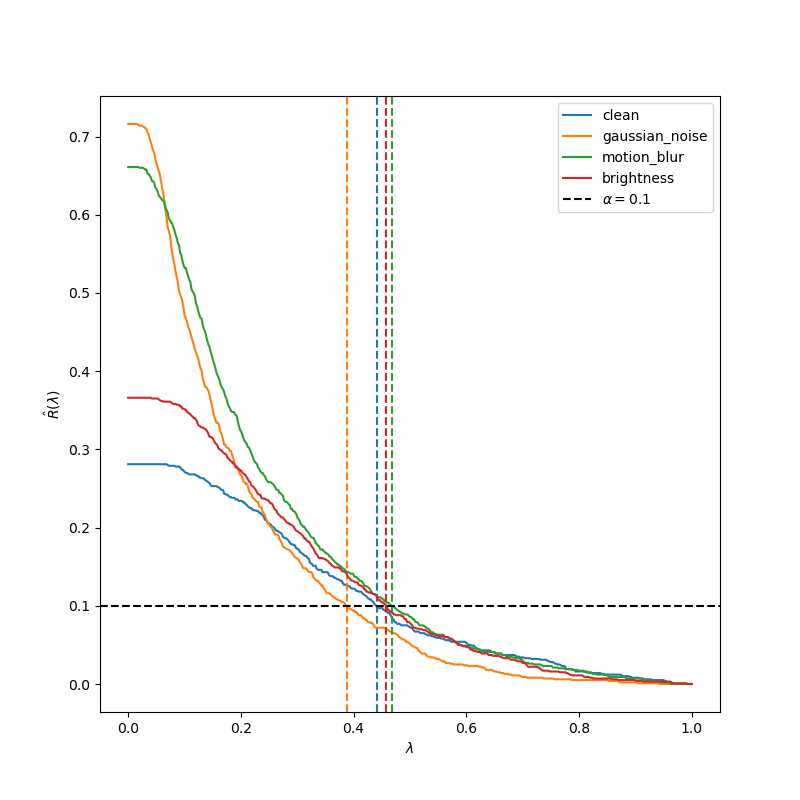

In [22]:
%matplotlib widget

from matplotlib.widgets import Slider, Button, RadioButtons
# plot risk for different lambdas
import matplotlib.pyplot as plt
import numpy as np

alpha= 0.1
lams = np.linspace(0,1,500)

y = [[] for i in range(len(curves))]
lam_threshs = [[] for i in range(len(curves))]
lam_hats = []

for i,curve in enumerate(curves):

    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()
    def lamhat_threshold(lam): 
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        return zo_loss(p_set, cal_preds_T[i]) - ((n+1)/n*alpha - 1/(n+1)) # why is this over n+1???

    
    for lam in lams:
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        y[i].append((p_set != cal_preds_T[i]).float().mean())
    lam_hats.append(brentq(lamhat_threshold, 0, 1))

fig,ax = plt.subplots(1,1,figsize=(8,8))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,curve in enumerate(curves):
    if curve == None:
        ax.plot(lams,y[i],label="clean",c=cycle[i])
    else:
        ax.plot(lams,y[i],label=corruptions[curve],c=cycle[i])
    ax.axvline(lam_hats[i],linestyle="--",c=cycle[i])
ax.axhline(alpha,c="k",linestyle="--",label=r"$\alpha = 0.1$")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$\hat{R}(\lambda)$")
ax.legend()


0

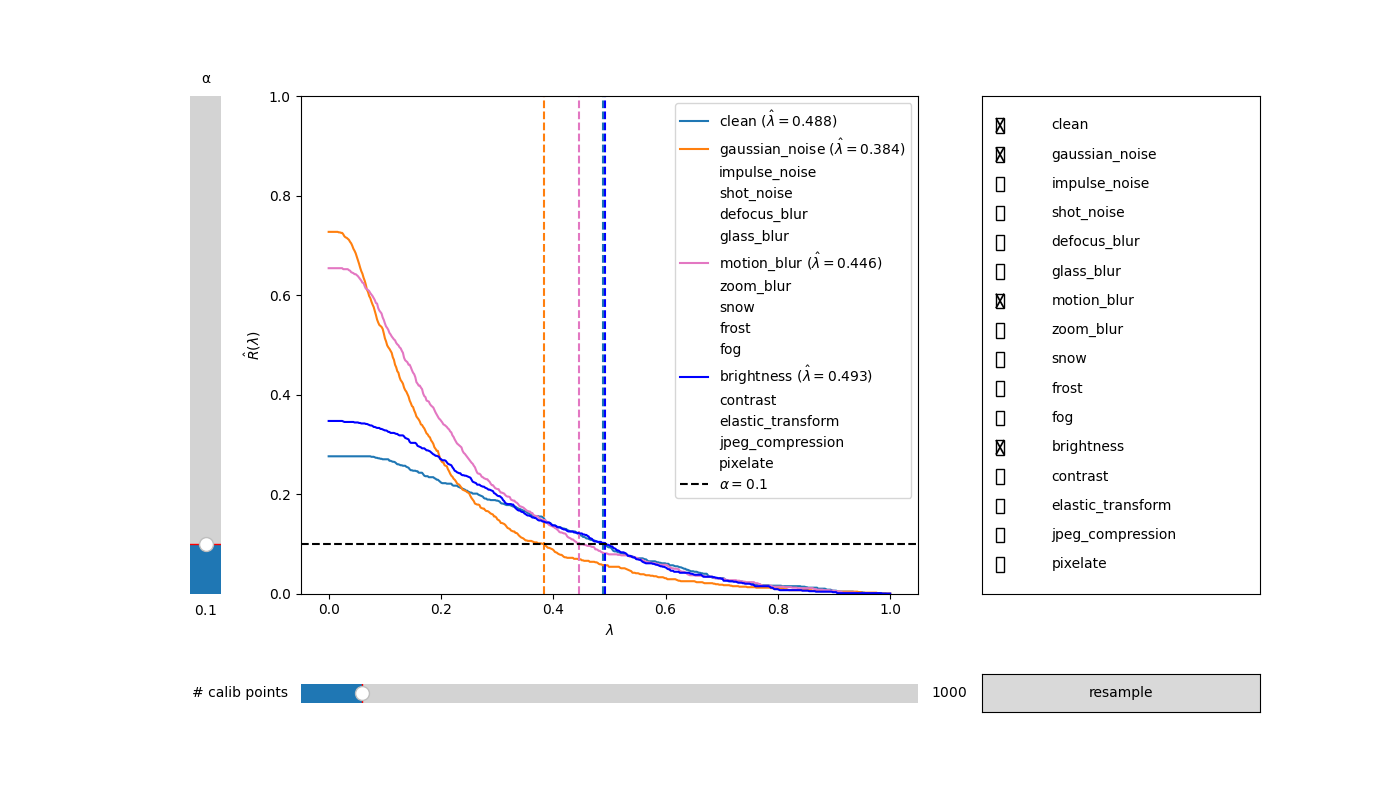

In [6]:
%matplotlib widget

from matplotlib.widgets import Slider, Button, RadioButtons,CheckButtons
# plot risk for different lambdas
import matplotlib.pyplot as plt
import numpy as np

fig,axs = plt.subplot_mosaic([['alpha','risk_curves','curve_selection'],
                              ['alpha','risk_curves','curve_selection'],
                              ['alpha','risk_curves','curve_selection'],
                              ['space','space','space'],
                              ['none','num_calib','resample']],figsize=(14,8),
                              gridspec_kw={'width_ratios':[0.1,1,0.45],
                                           'height_ratios': [1,1,1,0.25,0.25]})

# initialize widgets
alpha = Slider(axs['alpha'], 'α', 0, 1.0, valinit=0.1,orientation="vertical")
num_calib = Slider(axs['num_calib'], '# calib points', 0, 10000, valinit=1000,valstep=1,orientation="horizontal")
resample = Button(axs['resample'], 'resample')

axs['none'].axis('off')
axs['space'].axis('off')
# axs['curve_selection'].axis('off')
# axs['resample'].axis('off')

# static variables
curves = [None,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
curve_labels = ["clean"] + corruptions

confs = []
decs_S = []
decs_T = []

for curve in curves:
    if curve != None:
        student_confs,student_decs = torch.max(corr_preds_S[curve],dim=1)
        teacher_confs,teacher_decs = torch.max(corr_preds_T[curve],dim=1)
    else:
        student_confs,student_decs = torch.max(clean_preds_S,dim=1)
        teacher_confs,teacher_decs = torch.max(clean_preds_T,dim=1)
        
    confs.append(student_confs)
    decs_S.append(student_decs)
    decs_T.append(teacher_decs)

lams = np.linspace(0,1,500)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
cycle.extend(['k','b','lime','coral','khaki','deeppink'])


# dynamic variables, start with these initial conditions
torch.manual_seed(0)
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:num_calib.val]

cal_scores = []
cal_preds_S = []
cal_preds_T = []

init_curves = [None,0,5,10]

for i,curve in enumerate(curves):
    cal_scores.append(confs[i][cal_idxs])
    cal_preds_S.append(decs_S[i][cal_idxs])
    cal_preds_T.append(decs_T[i][cal_idxs])

y = [[] for i in range(len(curves))]
lam_threshs = [[] for i in range(len(curves))]
lam_hats = []

for i,curve in enumerate(curves):
    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()
    def lamhat_threshold(lam): 
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

    for lam in lams:
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        y[i].append((p_set != cal_preds_T[i]).float().mean())
    
    if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
    elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
    else:
        lamhat = brentq(lamhat_threshold, 0, 1)
    lam_hats.append(lamhat)


risk_lines = []
lambda_lines = []
for i,curve in enumerate(curves):
    if curve == None:
        l, = axs['risk_curves'].plot(lams,y[i],label="clean",c=cycle[i],visible=False)
        risk_lines.append(l)
    else:
        l, = axs['risk_curves'].plot(lams,y[i],label=corruptions[curve],c=cycle[i],visible=False)
        risk_lines.append(l)
    l = axs['risk_curves'].axvline(lam_hats[i],linestyle="--",c=cycle[i],visible=False)
    lambda_lines.append(l)

    if curve in init_curves:
        risk_lines[i].set_visible(True)
        risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        lambda_lines[i].set_visible(True)
alpha_line = axs['risk_curves'].axhline(alpha.val,c="k",linestyle="--",label=r"$\alpha = 0.1$")
axs['risk_curves'].set_xlabel("$\lambda$")
axs['risk_curves'].set_ylabel("$\hat{R}(\lambda)$")
axs['risk_curves'].legend()
axs['risk_curves'].set_ylim([0,1])

check = CheckButtons(
    ax=axs['curve_selection'],
    labels=curve_labels,
    actives=[l.get_visible() for l in risk_lines],
    # label_props={'color': cycle},
    # frame_props={'edgecolor': cycle},
    # check_props={'facecolor': cycle},
)


def alpha_update(val):
    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        if risk_lines[i].get_visible():
            risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
        axs['risk_curves'].legend()

alpha.on_changed(alpha_update)

def curve_update(label):
    
    risk_line = risk_lines[curve_labels.index(label)]
    lambda_line = lambda_lines[curve_labels.index(label)]
    
    risk_line.set_visible(not risk_line.get_visible())
    lambda_line.set_visible(not lambda_line.get_visible())
    risk_line.figure.canvas.draw_idle()
    lambda_line.figure.canvas.draw_idle()
    if risk_line.get_visible():
        risk_line.set_label(label+r" $(\hat{\lambda}=$"+str(round(lambda_line.get_data()[0],3))+")")
    else:
        risk_line.set_label(label)
    
    axs['risk_curves'].legend()

check.on_clicked(curve_update)


def num_calib_update(val):
    cal_idxs = rand_idxs[:num_calib.val]

    cal_scores = []
    cal_preds_S = []
    cal_preds_T = []

    init_curves = [None,0,5,10]

    for i,curve in enumerate(curves):
        cal_scores.append(confs[i][cal_idxs])
        cal_preds_S.append(decs_S[i][cal_idxs])
        cal_preds_T.append(decs_T[i][cal_idxs])

    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        risk_lines[i].set(ydata=y[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        if risk_lines[i].get_visible():
            risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
        else:
            risk_lines[i].set_label(curve_labels[i])
        axs['risk_curves'].legend()

num_calib.on_changed(num_calib_update)


def resample_update(val):
    rand_idxs = torch.randperm(50000)
    cal_idxs = rand_idxs[:num_calib.val]

    cal_scores = []
    cal_preds_S = []
    cal_preds_T = []

    init_curves = [None,0,5,10]

    for i,curve in enumerate(curves):
        cal_scores.append(confs[i][cal_idxs])
        cal_preds_S.append(decs_S[i][cal_idxs])
        cal_preds_T.append(decs_T[i][cal_idxs])

    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        risk_lines[i].set(ydata=y[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        if risk_lines[i].get_visible():
            risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
        else:
            risk_lines[i].set_label(curve_labels[i])
        axs['risk_curves'].legend()

resample.on_clicked(resample_update)

### Some Intuition

#### In general
* as $\lambda$ grows, then the risk goes down because the minimum student confidence goes up so we use the teacher more often
* If $\hat{\lambda}$ is **smaller**, that means we can use the student when it's less confident
    * this suggests the student and teacher agree more
* If $\hat{\lambda}$ is **bigger**, that means we should use the student when it's more confident
    * this suggests the student and teacher agree less